Clustering is a very common visualization technique in Business Intelligence. In marketing, you'll target people differently, say teens versus pensioners, and some groups are more valuable than others. Often very simple methods such as Principal component analysis (PCA) and k-means are employed for that purpose. In a first step dimensionality is reduced, then groups are separated by applying a clustering algorithm. 

Personally, I find it often frustrating to see these methods, especially when there are so many better methods. After all, PCA was proposed in 1901 (Karl Pearson, "On Lines and Planes of Closest Fit to Systems of Points in Space") and k-means in 1967 (James MacQueen, "Some Methods for classification and Analysis of Multivariate Observations"). While both methods had their place when data and computing resources were hard to come by, today many alternatives exist. 

Both PCA and k-means have serious shortcomings that affect its usefulness in practice. Since PCA operates over the correlation matrix, it can only find linear correlations between datapoints. This means that if variables are related, but not linearly (as you would see in a scatter-plot), then PCA would fail. Further, PCA is based on mean and variance, which are parameters for the Gaussian distribution. K-means, being a centroid based clustering algorithm, can only find spherical groups in a Euclidean space - i.e. if fails to uncover any more complicated structures [many limitations](https://developers.google.com/machine-learning/clustering/algorithm/advantages-disadvantages). Much more can be said about that, however, let's look at more modern ways to solve a typical application for clustering.

In this recipe, we'll go through a typical application of marketing segmentation, and we'll use modern, robust, nonlinear methods. In the end, we'll link to even more modern methods.

We download our [dataset from UCI](http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/). This dataset includes customer data that can serve to devise different strategy dependent on customer types. 

The dataset contains demographical and payment information about the customers. Depending on the group, 




In [1]:
import pandas as pd
import numpy as np

In [2]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data

--2020-10-11 23:29:37--  http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79793 (78K) [application/x-httpd-php]
Saving to: ‘german.data.1’

german.data.1       100%[===================>]  77.92K   165KB/s    in 0.5s    

2020-10-11 23:29:38 (165 KB/s) - ‘german.data.1’ saved [79793/79793]



In [3]:
names = ['existingchecking', 'duration', 'credithistory', 'purpose', 'creditamount', 
         'savings', 'employmentsince', 'installmentrate', 'statussex', 'otherdebtors', 
         'residencesince', 'property', 'age', 'otherinstallmentplans', 'housing', 
         'existingcredits', 'job', 'peopleliable', 'telephone', 'foreignworker', 'classification']

customers = pd.read_csv('german.data', names=names, delimiter=' ')


In [4]:
customers.head()

,existingchecking,duration,credithistory,purpose,creditamount,savings,employmentsince,installmentrate,statussex,otherdebtors,...,property,age,otherinstallmentplans,housing,existingcredits,job,peopleliable,telephone,foreignworker,classification
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [5]:
from sklearn.preprocessing import LabelEncoder

catvars = ['existingchecking', 'credithistory', 'purpose', 'savings', 'employmentsince',
           'statussex', 'otherdebtors', 'property', 'otherinstallmentplans', 'housing', 'job', 
           'telephone', 'foreignworker']
numvars = ['creditamount', 'duration', 'installmentrate', 'residencesince', 'age', 
           'existingcredits', 'peopleliable', 'classification']

dummyvars = pd.get_dummies(customers[catvars])
transactions = pd.concat([customers[numvars], dummyvars], axis = 1)

In [6]:
transactions.head()

,creditamount,duration,installmentrate,residencesince,age,existingcredits,peopleliable,classification,existingchecking_A11,existingchecking_A12,...,housing_A152,housing_A153,job_A171,job_A172,job_A173,job_A174,telephone_A191,telephone_A192,foreignworker_A201,foreignworker_A202
0,1169,6,4,4,67,2,1,1,1,0,...,1,0,0,0,1,0,0,1,1,0
1,5951,48,2,2,22,1,1,2,0,1,...,1,0,0,0,1,0,1,0,1,0
2,2096,12,2,3,49,1,2,1,0,0,...,1,0,0,1,0,0,1,0,1,0
3,7882,42,2,4,45,1,2,1,1,0,...,0,1,0,0,1,0,1,0,1,0
4,4870,24,3,4,53,2,2,2,1,0,...,0,1,0,0,1,0,1,0,1,0


In [7]:
'''
items_dict = {}

for _, customer in customers.iterrows():
    purchases = list(customer.values)
    for purchase in purchases:
      if purchase not in items_dict:
        items_dict[purchase] = len(items_dict)

transactions = np.zeros((len(customers), len(items_dict)))

for customer_index, customer in customers.iterrows():
    purchases = list(customer.values)
    for purchase in purchases:
      transactions[customer_index, items_dict[purchase]] = 1        
'''

'\nitems_dict = {}\n\nfor _, customer in customers.iterrows():\n    purchases = list(customer.values)\n    for purchase in purchases:\n      if purchase not in items_dict:\n        items_dict[purchase] = len(items_dict)\n\ntransactions = np.zeros((len(customers), len(items_dict)))\n\nfor customer_index, customer in customers.iterrows():\n    purchases = list(customer.values)\n    for purchase in purchases:\n      transactions[customer_index, items_dict[purchase]] = 1        \n'

Text(0.5, 0, 'dimensions')

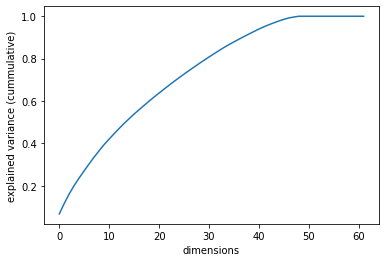

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
import matplotlib.pyplot as plt

pca = PCA().fit(
    StandardScaler().fit_transform(transactions)
)
ax = plt.plot(
    range(len(pca.explained_variance_ratio_)), 
    np.cumsum(pca.explained_variance_ratio_)
)
plt.ylabel('explained variance (cummulative)')
plt.xlabel('dimensions')

In [9]:
len(transactions.columns)

62

In [10]:
#let's find a good dimensionality reduction
from sklearn.manifold import LocallyLinearEmbedding

dimensions_range = [10, 20]
reconstruction_errors = np.zeros((dimensions_range[1]))
for n_components in range(*dimensions_range):
  lle = LocallyLinearEmbedding(
      n_components=n_components, n_jobs=-1, #eigen_solver='auto', n_neighbors=2
  ).fit(transactions)
  reconstruction_errors[n_components] = lle.reconstruction_error_

Text(0.5, 0, 'dimensions')

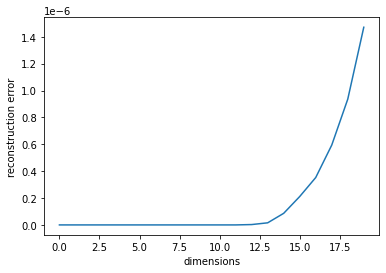

In [11]:
import matplotlib.pyplot as plt
plt.plot(list(range(dimensions_range[1])), reconstruction_errors)
plt.ylabel('reconstruction error')
plt.xlabel('dimensions')

In [12]:
reconstruction_errors[dimensions_range[0]-1:]

array([0.00000000e+00, 5.97277824e-15, 4.53648713e-15, 2.67953071e-09,
       1.55691443e-08, 8.63104004e-08, 2.11263688e-07, 3.52622045e-07,
       5.93974854e-07, 9.35832024e-07, 1.47094691e-06])

In [13]:
n_components = np.argmin(reconstruction_errors[dimensions_range[0]:]) + dimensions_range[0]+1
print('chosen dimensions: {}'.format(n_components))
lle = LocallyLinearEmbedding(
    n_components=n_components, eigen_solver='auto', n_neighbors=2
).fit(transactions)
transactions_reduced = lle.transform(transactions)

chosen dimensions: 12


In [14]:
from sklearn.cluster import AffinityPropagation
clustering = AffinityPropagation(damping=0.9).fit(transactions_reduced)

/Users/ben/anaconda3/lib/python3.6/site-packages/sklearn/cluster/_affinity_propagation.py:152: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning)


In [15]:
np.unique(clustering.predict(transactions_reduced))

array([0])

In [18]:
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.base import TransformerMixin

class Reduce(TransformerMixin):
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    return X[:, :2]


def plot_decision_boundary(data, kmeans, title='No title', h=.001, model=None, highlight_centroids=False, ica=Reduce()):
    '''Based on https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html
  
    Parameters
    ----------
    data - the dataset to be visualized with clusters
    kmeans - the clustering algorithm
    title - the title to displayed with the plot
    h - Step size of the mesh. Decrease to increase the quality of the VQ.
    model - model to re-learn projections in lower-dimensional space. Don't if None.
    highlight_centroids - whether to show the centroids (False)
      centroids might have little bearing in a different space.
    ica - a dimensionality reduction method with fit and transform. This has to result in
      two dimensions, e.g. FastICA(n_components=2)
    '''
    #ica = ica.fit(data)
    reduced_data = ica.fit_transform(data)
    if model is not None:
      svc = model.fit(reduced_data, kmeans.predict(data))
    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1e-15, reduced_data[:, 0].max() + 1e-15
    y_min, y_max = reduced_data[:, 1].min() - 1e-15, reduced_data[:, 1].max() + 1e-15
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    if model:
      preds = svc.predict(
              np.c_[xx.ravel(), yy.ravel()]
      )
    elif data.shape[1] == 2:
      preds = kmeans.predict(
              np.c_[xx.ravel(), yy.ravel()]
      )
    else:
      preds = kmeans.predict(
          ica.inverse_transform(
              np.c_[xx.ravel(), yy.ravel()]
          )
      )
    pred_dict = {predval: i for i, predval in enumerate(np.unique(preds))}
    Z = preds.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(
        Z, interpolation=None,
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        cmap=plt.cm.Paired,
        aspect='auto', origin='lower',
    )

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    plt.colorbar()
    if highlight_centroids:
    # Plot the centroids as a white X
      centroids = ica.transform(kmeans.cluster_centers_)
      centroids = np.array(
          [centroid for i, centroid in enumerate(centroids) if i in pred_dict]
      )
      plt.scatter(
          centroids[:, 0], centroids[:, 1],
          marker='x', s=169, linewidths=3,
          color='w', zorder=10
      )
    plt.title(title)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()


In [19]:
y = clustering.predict(lle.transform(transactions))

In [20]:
transactions.join(pd.DataFrame(data=y, columns=['y'])).groupby(by='y').mean()

,creditamount,duration,installmentrate,residencesince,age,existingcredits,peopleliable,classification,existingchecking_A11,existingchecking_A12,...,housing_A152,housing_A153,job_A171,job_A172,job_A173,job_A174,telephone_A191,telephone_A192,foreignworker_A201,foreignworker_A202
y,,,,,,,,,,,,,,,,,,,,,
0,3271.258,20.903,2.973,2.845,35.546,1.407,1.155,1.3,0.274,0.269,...,0.713,0.108,0.022,0.2,0.63,0.148,0.596,0.404,0.963,0.037


We could also argue that what really matters to us is that customers can pay back the loans. For example, when we pay marketing expenses, we want to really spend on the potential customers that we can make money with or (reversely) don't lose with.

In [21]:
X = transactions.drop(columns=['classification'])
y = transactions['classification']

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier().fit(X, y)

In [23]:
DP, n_nodes_ptr = rf.decision_path(X)
# The columns from indicator[n_nodes_ptr[i]:n_nodes_ptr[i+1]] gives the indicator value for the i-th estimator.


In [24]:
n_nodes_ptr

array([    0,   481,   912,  1403,  1842,  2301,  2774,  3249,  3734,
        4203,  4738,  5251,  5726,  6197,  6662,  7127,  7588,  8115,
        8576,  9051,  9482,  9957, 10404, 10915, 11338, 11799, 12282,
       12747, 13202, 13687, 14160, 14623, 15044, 15493, 15904, 16385,
       16886, 17381, 17824, 18235, 18694, 19181, 19656, 20129, 20604,
       21075, 21540, 21959, 22398, 22861, 23350, 23791, 24240, 24729,
       25252, 25723, 26198, 26627, 27092, 27557, 28024, 28495, 28986,
       29489, 29974, 30413, 30834, 31267, 31758, 32243, 32694, 33179,
       33640, 34113, 34604, 35085, 35572, 36057, 36528, 37031, 37496,
       37977, 38466, 38953, 39428, 39859, 40340, 40787, 41242, 41699,
       42138, 42651, 43126, 43659, 44142, 44645, 45134, 45591, 46024,
       46483, 46892])

In [25]:
DP.shape

(1000, 46892)

In [26]:
def reduce_decision_path(indicator, n_nodes_ptr, level=2):
  def level_offsets(level):
    if level > 0:
      return np.array([2**(level-1), 2**level], dtype=np.int64)
    else:
      return np.array([0, 1], dtype=np.int64)

  n_estimators = len(n_nodes_ptr)
  X = indicator.todense()
  offsets = level_offsets(level)
  nodes = []
  for est_ptr in n_nodes_ptr:
    indices = offsets+est_ptr
    if indices[-1] <= X.shape[1]:
      nodes.append(X[:, indices[0]: indices[1]])  #.reshape(X.shape[0], indices.shape[-1]))
  return np.column_stack(nodes)

In [27]:
matrix = StandardScaler().fit_transform(np.column_stack([                                                      
  reduce_decision_path(DP, n_nodes_ptr, level=1).mean(axis=-1),
  reduce_decision_path(DP, n_nodes_ptr, level=2).mean(axis=-1),
]))

In [28]:
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform

distances = squareform(pdist(matrix))
clustering = AffinityPropagation(damping=0.9).fit(distances)
clustering2 = AgglomerativeClustering(
    n_clusters=5, affinity='precomputed', linkage='average'
).fit(distances)

/Users/ben/anaconda3/lib/python3.6/site-packages/sklearn/cluster/_affinity_propagation.py:152: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning)


In [29]:
np.max(clustering.predict(distances))

14

In [30]:
y = clustering.predict(distances)
clusters = transactions.join(
    pd.DataFrame(data=y, columns=['cluster'])
).groupby(by='cluster').agg(
    age_mean=pd.NamedAgg(column='age', aggfunc='mean'),
    age_std=pd.NamedAgg(column='age', aggfunc='std'),
    creditamount=pd.NamedAgg(column='creditamount', aggfunc='mean'),
    duration=pd.NamedAgg(column='duration', aggfunc='mean'),
    count=pd.NamedAgg(column='age', aggfunc='count'),
    class_mean=pd.NamedAgg(column='classification', aggfunc='mean'),
    class_std=pd.NamedAgg(column='classification', aggfunc='std'),
).sort_values(by='class_mean')
clusters

,age_mean,age_std,creditamount,duration,count,class_mean,class_std
cluster,,,,,,,
5,34.864865,11.394933,2518.837838,17.459459,74,1.202703,0.404757
0,34.029851,11.262663,2578.492537,17.835821,67,1.208955,0.409631
11,39.740741,13.357777,6341.259259,34.370370,27,1.222222,0.423659
12,39.445946,11.125858,4091.094595,26.972973,74,1.229730,0.423530
2,32.523810,10.704998,2472.476190,16.738095,42,1.238095,0.431081
3,37.851064,11.313668,5182.255319,27.170213,47,1.255319,0.440755
4,33.000000,11.904926,1741.434783,13.217391,23,1.260870,0.448978
7,39.000000,11.317636,4075.659341,23.307692,91,1.263736,0.443099
1,33.183673,10.821272,3266.959184,20.663265,98,1.285714,0.454077


In [31]:
pip install dython

Note: you may need to restart the kernel to use updated packages.


In [32]:
from dython.nominal import correlation_ratio

In [33]:
from dython.nominal import associations

In [34]:
correlation_ratio(transactions['classification'].values, y)

0.06483765834312989

In [35]:
y = clustering2.labels_
clusters = transactions.join(
    pd.DataFrame(data=y, columns=['cluster'])
).groupby(by='cluster').agg(
    age_mean=pd.NamedAgg(column='age', aggfunc='mean'),
    age_std=pd.NamedAgg(column='age', aggfunc='std'),
    creditamount=pd.NamedAgg(column='creditamount', aggfunc='mean'),
    duration=pd.NamedAgg(column='duration', aggfunc='mean'),
    count=pd.NamedAgg(column='age', aggfunc='count'),
    class_mean=pd.NamedAgg(column='classification', aggfunc='mean'),
    class_std=pd.NamedAgg(column='classification', aggfunc='std'),
).sort_values(by='class_mean')
clusters

,age_mean,age_std,creditamount,duration,count,class_mean,class_std
cluster,,,,,,,
3,47.000000,NaN,5103.000000,24.000000,1,1.000000,NaN
1,38.979079,11.482339,4533.991632,26.326360,239,1.238494,0.427057
2,33.959108,11.343443,2616.107807,17.613383,269,1.249071,0.433281
0,31.202703,10.389641,1752.094595,13.108108,74,1.283784,0.453911
4,35.345324,11.016844,3235.354916,21.292566,417,1.371703,0.483840


In [36]:
correlation_ratio(transactions['classification'].values, y)

0.11809909247898157

In [37]:
distances = squareform(pdist(
    StandardScaler().fit_transform(
        transactions[['classification', 'creditamount', 'duration']]
    )
))
clustering3 = AffinityPropagation(damping=0.9).fit(distances)
clustering4 = AgglomerativeClustering(
    n_clusters=5, affinity='precomputed', linkage='average'
).fit(distances)

/Users/ben/anaconda3/lib/python3.6/site-packages/sklearn/cluster/_affinity_propagation.py:152: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning)


In [38]:
print(np.max(clustering3.predict(distances)))
print(correlation_ratio(transactions['classification'].values, clustering3.predict(distances)))
print(correlation_ratio(transactions['classification'].values, clustering4.labels_))

23
0.00887681559456858
0.3178388028194592


In [39]:
y = clustering4.labels_
clusters = transactions.join(
    pd.DataFrame(data=y, columns=['cluster'])
).groupby(by='cluster').agg(
    age_mean=pd.NamedAgg(column='age', aggfunc='mean'),
    age_std=pd.NamedAgg(column='age', aggfunc='std'),
    creditamount=pd.NamedAgg(column='creditamount', aggfunc='mean'),
    duration=pd.NamedAgg(column='duration', aggfunc='mean'),
    count=pd.NamedAgg(column='age', aggfunc='count'),
    class_mean=pd.NamedAgg(column='classification', aggfunc='mean'),
    class_std=pd.NamedAgg(column='classification', aggfunc='std'),
).sort_values(by='class_mean')
clusters

,age_mean,age_std,creditamount,duration,count,class_mean,class_std
cluster,,,,,,,
4,35.920000,7.348025,8289.740000,42.640000,50,1.000000,0.000000
2,35.548165,11.489624,2473.405963,17.779817,872,1.259174,0.438433
0,38.200000,16.457352,15271.600000,51.300000,10,1.600000,0.516398
1,34.530303,10.989813,7845.363636,41.545455,66,2.000000,0.000000
3,45.500000,31.819805,14725.500000,6.000000,2,2.000000,0.000000


In [41]:
# this is from napkin-ml
# https://github.com/eriklindernoren/NapkinML/blob/master/napkin_ml/utils/misc.py
class Plot():
    def __init__(self, colormap='viridis'):
        self.cmap = plt.get_cmap(colormap)

    def _transform(self, X, dim):
        e_val, e_vec = np.linalg.eig(np.cov(X, rowvar=False))
        idx = e_val.argsort()[::-1]
        e_vec = e_vec[:, idx][:, :dim]
        return X.dot(e_vec)

    # Plot the dataset X and the corresponding labels y in 2D using PCA.
    def plot_in_2d(self, X, y=None, title=None, accuracy=None, legend_labels=None):
        X_transformed = self._transform(X, dim=2)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        class_distr = []

        y = np.array(y).astype(int)

        colors = [self.cmap(i) for i in np.linspace(0, 1, len(np.unique(y)))]

        # Plot the different class distributions
        for i, l in enumerate(np.unique(y)):
            _x1 = x1[y == l]
            _x2 = x2[y == l]
            _y = y[y == l]
            class_distr.append(plt.scatter(_x1, _x2, color=colors[i]))

        # Plot legend
        if not legend_labels is None:
            plt.legend(class_distr, legend_labels, loc=1)

        # Plot title
        if title:
            if accuracy:
                perc = 100 * accuracy
                plt.suptitle(title)
                plt.title("Accuracy: %.1f%%" % perc, fontsize=10)
            else:
                plt.title(title)

        # Axis labels
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')

        plt.show()


In [42]:
import jax.numpy as jnp
import numpy as np
from jax import grad, jit, vmap
from sklearn.base import ClassifierMixin
import jax
import random
from scipy.stats import hmean


class KMeans(ClassifierMixin):
    def __init__(self, k, n_iter=100):
      self.k = k
      self.n_iter = n_iter
      self.euclidean = jit(vmap(
          lambda x, y: jnp.linalg.norm(
              x - y, ord=2, axis=-1, keepdims=False
          ), in_axes=(0, None), out_axes=0
      ))
      
    def adjust_centers(self, X):
        jnp.row_stack([X[self.clusters == c].mean(axis=0)
          for c in self.clusters
        ])

    def initialize_centers(self):
        '''roughly the kmeans++ initialization
        '''
        key = jax.random.PRNGKey(0)
        # jax doesn't have uniform_multivariate
        self.centers = jax.random.multivariate_normal(
            key, jnp.mean(X, axis=0), jnp.cov(X, rowvar=False), shape=(1,)
        )
        for c in range(1, self.k):
            weights = self.euclidean(X, self.centers)
            if c>1:
              weights = hmean(weights ,axis=-1)
              print(weights.shape)

            new_center = jnp.array(
                random.choices(X, weights=weights, k=1)[0],
                ndmin=2
            )
            self.centers = jnp.row_stack(
                (self.centers, new_center)
            )
            print(self.centers.shape)

    def fit(self, X, y=None):
        self.initialize_centers()
        for iter in range(self.n_iter):
            dists = self.euclidean(X, self.centers)
            self.clusters = jnp.argmin(dists, axis=-1)
            self.adjust_centers(X)
        return self.clusters

import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

X, y = load_iris(return_X_y=True)

kmeans = KMeans(k=3)
kmeans.fit(X)

/Users/ben/anaconda3/lib/python3.6/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


(2, 4)
(150,)
(3, 4)


DeviceArray([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
             2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
             2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2,
             1, 2, 1, 0, 2, 0, 0, 2, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2,
             1, 1, 2, 0, 2, 0, 0, 0, 2, 1, 2, 0, 2, 1, 2, 2, 2, 0, 1, 2,
             0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

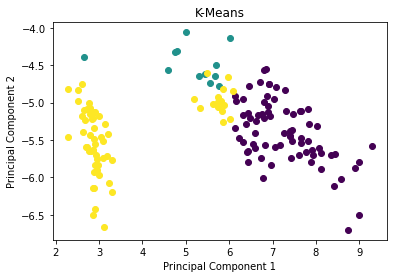

In [43]:
Plot().plot_in_2d(X, kmeans.clusters, "K-Means")

You can find a good comparison of [clustering methods in the scikit-learn documentation](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py).

